# Environment

In [1]:
import os
import io
import time
import requests
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# clone the git repository and set it as the working directory
! git clone https://github.com/martin-marek/parking-space-occupancy
os.chdir('parking-space-occupancy')

In [3]:
# download the dataset
if not os.path.exists('dataset/data'):
    r = requests.get("https://storage.googleapis.com/pd-datasets/rois_gopro.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('dataset/data')

# Visualize dataset

In [4]:
from dataset import acpds
from utils import transforms
from utils import visualize as vis

In [5]:
train_ds, valid_ds, test_ds = acpds.create_datasets('dataset/data')

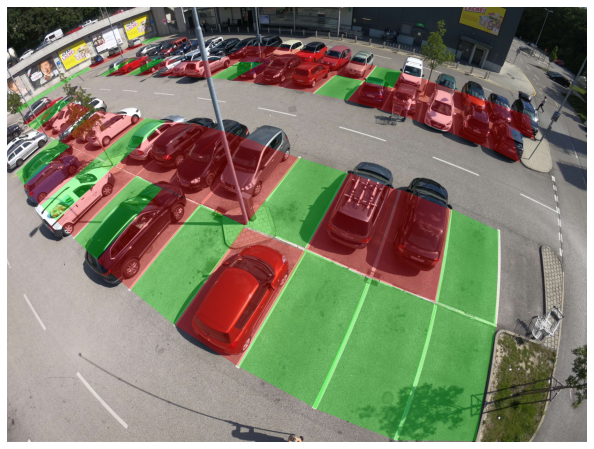

In [6]:
image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = transforms.preprocess(image_raw, res=1440)
vis.plot_ds_image(image, rois, labels, show=True)

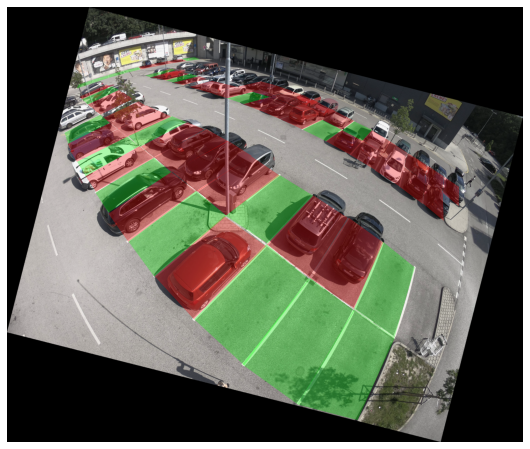

In [7]:
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image_aug, rois_aug = transforms.augment(image_raw, rois)
image_aug = transforms.preprocess(image_aug, res=1440)
vis.plot_ds_image(image_aug, rois_aug, labels, show=True)

# Plot model predictions

In [8]:
# create model
from models.rcnn import RCNN
model = RCNN()

# load model weights
weights_path = 'weights.pt'
if not os.path.exists(weights_path):
    r = requests.get('https://storage.googleapis.com/pd-models/RCNN_128_square_gopro.pt')  
    with open(weights_path, 'wb') as f:
        f.write(r.content)
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


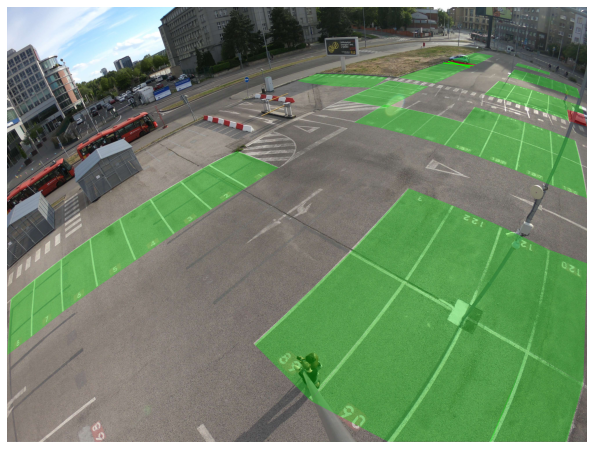

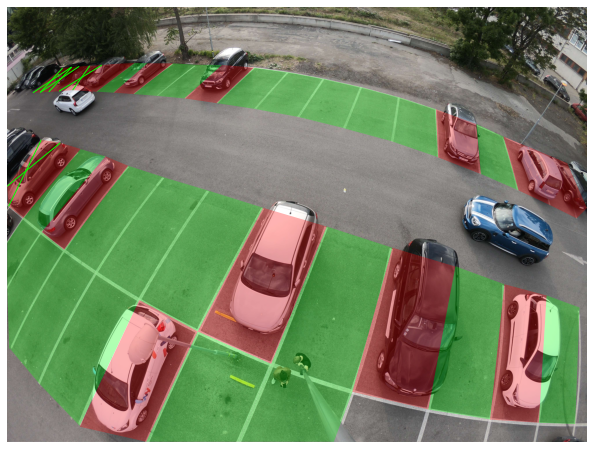

In [9]:
# plot test predictions
for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    if i == 2: break
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    image = transforms.preprocess(image)
    with torch.no_grad():
        class_logits = model(image, rois)
        class_scores = class_logits.softmax(1)[:, 1]
    vis.plot_ds_image(image, rois, class_scores, labels)    

# Plot ROI warps

In [10]:
from models.utils import pooling

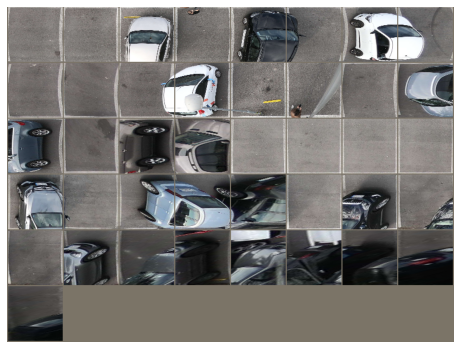

In [11]:
warps = pooling.roi_pool(image, rois, 100, 'qdrl')
vis.show_warps(warps)

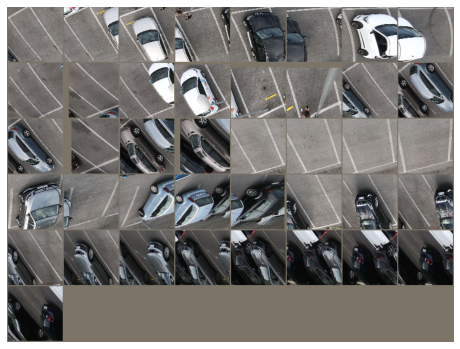

In [12]:
warps = pooling.roi_pool(image, rois, 100, 'square')
vis.show_warps(warps)

# Speed comparison

In [14]:
from models.rcnn import RCNN
from models.faster_rcnn_fpn import FasterRCNN_FPN

In [15]:
def time_model(model, res=[1920, 1440], n=3):
    image = torch.zeros([3, res[1], res[0]])
    L_arr = torch.linspace(1, 100, steps=10, dtype=torch.int32)
    mean = np.zeros_like(L_arr, dtype=np.float32)
    ese = np.zeros_like(L_arr, dtype=np.float32)
    for i, L in enumerate(L_arr):
        times = np.zeros(n)
        for j in range(n):
            rois = torch.rand([L, 4, 2])
            t0 = time.time()
            out = model(image, rois)
            t1 = time.time()
            times[j] = t1 - t0
        mean[i] = np.mean(times)
        ese[i] = np.std(times) / np.sqrt(len(times))
    return L_arr, mean, ese

In [16]:
times = {}
times['R-CNN (64)']  = time_model(RCNN(roi_res=64),  res=[4000, 3000])
times['R-CNN (128)'] = time_model(RCNN(roi_res=128), res=[4000, 3000])
times['R-CNN (256)'] = time_model(RCNN(roi_res=256), res=[4000, 3000])
times['Faster R-CNN FPN (800)']   = time_model(FasterRCNN_FPN(), res=[1067, 800])
times['Faster R-CNN FPN (1100)']  = time_model(FasterRCNN_FPN(), res=[1467, 1100])
times['Faster R-CNN FPN (1440)']  = time_model(FasterRCNN_FPN(), res=[1920, 1440])

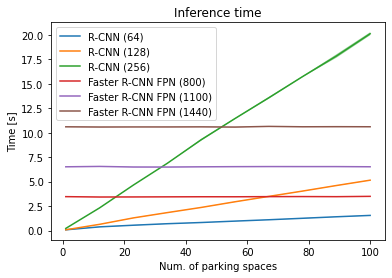

In [18]:
for k, v in times.items():
    plt.plot(v[0], v[1], label=k)
    plt.fill_between(v[0], v[1]-v[2], v[1]+v[2], alpha=0.5)

plt.title('Inference time')
plt.xlabel('Num. of parking spaces')
plt.ylabel('Time [s]')
plt.legend()
plt.show()

# FPN level resolutions

In [19]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
backbone = resnet_fpn_backbone('resnet50', pretrained=False)
image = torch.zeros([3, 1920, 1440])
out = backbone.body(image[None])
for k, v in out.items():
    print(k, v.shape)

0 torch.Size([1, 256, 480, 360])
1 torch.Size([1, 512, 240, 180])
2 torch.Size([1, 1024, 120, 90])
3 torch.Size([1, 2048, 60, 45])
